## **Task**

Imagine that you work for a large dating app.

In addition to the basic functions, the app also has a premium subscription, which gives access to a number of important additional features. An A/B test was conducted, in which the premium subscription price was changed for new users from **several countries** when purchasing through **two new payment systems**. At the same time, the cost of the trial period remained the same.

**Check whether the experiment was successful overall.**
**Specify H0 and H1 for the statistical tests you perform**

Money for the subscription is debited monthly until the user cancels it.

There are three groups in total: test, control 1 (control_1), and control 2 (control_2). For each of them:

users_*.csv – information about users:

+ uid – user ID
+ age
+ attraction_coeff (from 0 to 1000, (likes/views)*1000)
+ coins – number of coins (internal currency)
+ country
+ visit_days – on what days after registration the user visited the application (e.g. on 1, then on 7)
+ gender
+ age_filter_start – search filter, min. value
+ age_filter_end – search filter, max. value
+ views_count – number of ratings received
+ was_premium – whether premium was ever purchased (either a trial period of premium status or purchased for money)
+ is_premium – is currently premium or not
+ total_revenue – standardized revenue

transactions_*.csv – information about user payments:

+ uid – user identifier
+ country
+ joined_at – date and time of registration
+ paid_at – date and time of purchase
+ revenue – revenue
+ payment_id
+ from_page – where the user went to the payment page from
+ product_type – product type (trial_premium – trial premium subscription, premium_no_trial – premium subscription without trial, + coins – subscription for internal currency, other_type – other)

**Files**:

+ users_test – information about the users in the test group.
+ users_control_1 – information about the users in the first control group.
+ users_control_2 – information about the users in the second control group.
+ transactions_test – information about payments by users in the test group.
+ transactions_control_1 – information about payments by users in the first control group.
+ transactions_control_2 – information about payments by users in the second control group.

In [143]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2
import matplotlib.pyplot as plt

In [144]:
# reading the data
users_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/users_test.csv', sep=';')
users_control_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/users_control_2.csv', sep=';')
transactions_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/transactions_test.csv', sep=';', parse_dates=['joined_at','paid_at'])
transactions_control_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/transactions_control_1.csv', sep=';', parse_dates=['joined_at','paid_at'])
transactions_control_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-leschinskaja/Project_data/transactions_control_2.csv', sep=';', parse_dates=['joined_at','paid_at'])

## Exploratory Data Analysis
1. For all tables, I'll check:
    + Missing values;
    + Whether IDs are unique for each group;
    + Duplicates.
2. Select users in the control and test groups according to the following conditions:
    + Identify countries and payment systems for which a new price was introduced, and leave only the necessary ones;
    + Check the dates of the A/B test and remove outliers based on the registration date;
    + Check that for all users, registration occurred earlier than the transaction.
3. Assess how balanced the test and control groups are by:
    + Key socio-demographic indicators (age, gender);
    + Application-specific indicators (attractiveness coefficient, number of coins, number of views, number of days in the application).
4. Compare the number of users and revenue from users and transactions

### Users (Step 1)

In [145]:
#Let's have a look at the data
users_control_1.info()
users_control_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [146]:
users_control_2.info()
users_control_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [147]:
users_test.info()
users_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


Let's handle the missing data

In [148]:
#We see that the missing variables are coins, visit_days, was_premium, is_premium
#For all variables except visit_days, let's see what values are possible
users_control_1.coins.describe() #Here we use the describe method to look at the minimum values

count       60.0000
mean      1745.9000
std      12902.3577
min          1.0000
25%          8.0000
50%         11.5000
75%         28.0000
max      99958.0000
Name: coins, dtype: float64

In [149]:
users_control_1.was_premium.unique()

array([nan,  1.])

In [150]:
users_control_1.is_premium.unique()

array([nan,  1.])

We see that, most likely, NaN in this case is equivalent to 0 - if there are no coins/subscriptions, the system does not record this.

visit_days is on what days after registration the user visited the application, we can also replace NaN with 0 (visited only upon registration)

In [151]:
users_control_1[['coins','was_premium','is_premium', 'visit_days']]\
=users_control_1[['coins','was_premium','is_premium', 'visit_days']].fillna(0)

In [152]:
#Checking that everything is OK
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             4340 non-null   float64
 4   country           4340 non-null   object 
 5   visit_days        4340 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       4340 non-null   float64
 11  is_premium        4340 non-null   float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [153]:
users_control_2[['coins','was_premium','is_premium', 'visit_days']]\
=users_control_1[['coins','was_premium','is_premium', 'visit_days']].fillna(0)
users_test[['coins','was_premium','is_premium', 'visit_days']]\
=users_test[['coins','was_premium','is_premium', 'visit_days']].fillna(0)

In [154]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             4264 non-null   float64
 4   country           4264 non-null   object 
 5   visit_days        4264 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       4264 non-null   float64
 11  is_premium        4264 non-null   float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [155]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             4308 non-null   float64
 4   country           4308 non-null   object 
 5   visit_days        4308 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       4308 non-null   float64
 11  is_premium        4308 non-null   float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


Now let's check whether all IDs are unique between the two control and test groups. That is, let's check that a) the splitting algorithm works correctly, b) both tables with the control group have different IDs, they do not intersect

In [156]:
test = set(users_test.uid)
control1 = set(users_control_1.uid)
control2 = set(users_control_2.uid)

test & control1 & control2

set()

We got an empty set. This means that all IDs are unique. We can assign the corresponding labels: test, control1 and control2.

In [157]:
users_test['group'] = 'test'
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test


In [158]:
users_control_1['group'] = 'control1'
users_control_2['group'] = 'control2'
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0.0,0,control1
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,0.0,0.0,0,control1
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0.0,0,control1
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0.0,0,control1
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0.0,0,control1


In [159]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892035504,37,137,0.0,Israel,"1,2,3,4,5,6",1,30,40,51,0.0,0.0,0,control2
1,891782112,57,0,0.0,Italy,"1,2",1,54,60,0,0.0,0.0,0,control2
2,891110337,30,769,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,27,33,13,0.0,0.0,0,control2
3,891796320,48,750,0.0,France,"1,2,3,4,5",1,45,51,12,0.0,0.0,0,control2
4,891880212,54,638,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,35,53,94,0.0,0.0,0,control2


Let's merge the users datasets

In [160]:
users = pd.concat([users_test, users_control_1, users_control_2], axis=0)\
.reset_index(drop=True) 

In [161]:
#Checking that everything works
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test


In [162]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             12912 non-null  float64
 4   country           12912 non-null  object 
 5   visit_days        12912 non-null  object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       12912 non-null  float64
 11  is_premium        12912 non-null  float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
dtypes: float64(3), int64(8), object(3)
memory usage: 1.4+ MB


In [163]:
users.group.unique()

array(['test', 'control1', 'control2'], dtype=object)

Now that all user data are presented in one table, let's check the data for duplicates.

In [164]:
users.loc[users.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group


All data are unique.

Now it's better to transform the variable visit_days (on what days after registration the user visited the application). In its current form, its further use in analysis is difficult.

Let's create 2 variables: visit_number - the number of days the user visited the application; last_visit - how many days after registration the user last visited the application

In [165]:
#Splitting the string into elements and counting their number
users['visit_number'] = users.visit_days.str.split(',').str.len()

In [166]:
#Splitting the string, keeping the last element
users['last_visit'] = users.visit_days.str.split(',').str[-1]

In [167]:
users.head() 

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,14.0,17
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,NaN,NaN
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,20.0,26
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,12.0,12
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,NaN,NaN


In [168]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             12912 non-null  float64
 4   country           12912 non-null  object 
 5   visit_days        12912 non-null  object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       12912 non-null  float64
 11  is_premium        12912 non-null  float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
 14  visit_number      8952 non-null   float64
 15  last_visit        8952 non-null   object 
dtypes: float64(4), int64(8), object(4)
memor

In [169]:
#Let's check what the missing values in the new variables mean
users.query("visit_number=='NaN' | last_visit=='NaN'")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,NaN,NaN
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,NaN,NaN
6,891304281,39,0,0.0,France,0,1,36,42,0,0.0,0.0,0,test,NaN,NaN
7,892431420,21,909,0.0,Australia,0,1,18,24,11,0.0,0.0,0,test,NaN,NaN
13,891219699,30,1000,0.0,United States of America,0,1,27,33,1,1.0,0.0,0,test,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12885,891693531,26,0,0.0,Spain,0,1,23,29,1,0.0,0.0,0,control2,NaN,NaN
12896,891092556,24,0,0.0,Argentina,0,1,21,27,2,0.0,0.0,0,control2,NaN,NaN
12900,891332760,50,0,0.0,Chile,0,1,47,53,3,0.0,0.0,0,control2,NaN,NaN
12902,891693195,26,0,0.0,Spain,0,1,23,29,2,0.0,0.0,0,control2,NaN,NaN


In [170]:
#Let's check whether missing data are for visit_days=0 only
users.query("visit_number=='NaN' & visit_days!=0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit


In [171]:
users.query("last_visit=='NaN' & visit_days!=0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit


In [172]:
#We can replace NaN with 0
users = users.fillna(0)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             12912 non-null  float64
 4   country           12912 non-null  object 
 5   visit_days        12912 non-null  object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       12912 non-null  float64
 11  is_premium        12912 non-null  float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
 14  visit_number      12912 non-null  float64
 15  last_visit        12912 non-null  object 
dtypes: float64(4), int64(8), object(4)
memor

### transactions (Step 1)

In [173]:
#Let's have a look at the data
transactions_control_1.info()
transactions_control_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [174]:
#We can see many empty rows, let's delete them
transactions_control_1=transactions_control_1.dropna()

In [175]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 26.5+ KB


In [176]:
transactions_control_2.info()
transactions_control_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [177]:
transactions_test.info()
transactions_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


There are no missing values in the remaining dataframes. Let's check whether all tables contain data from different users.

In [178]:
test_tr = set(transactions_test.uid)
control1_tr = set(transactions_control_1.uid)
control2_tr = set(transactions_control_2.uid)

test_tr & control1_tr & control2_tr #the users are unique

set()

Let's check that the users from the users and transactions tables are the same.

In [179]:
test_tr - test

set()

In [180]:
control1_tr - control1

set()

In [181]:
control2_tr - control2

set()

Everything is fine. Let's check the data for duplicates and see if all the rows contain unique users.

In [182]:
transactions_test.loc[transactions_test.duplicated(keep=False)].sort_values('uid') 
#I added a parameter that allows you to keep both duplicates in the output to check the code

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
15,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
80,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
179,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
17,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


In [183]:
#Duplicates are identified correctly, we can delete them
transactions_test = transactions_test.drop_duplicates()

In [184]:
transactions_control_1.loc[transactions_control_1.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
93,891367521.0,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
176,892207959.0,France,2017-10-18 18:30:00,2017-10-22 04:49:00,1261.0,19.0,empty_likes,coins
198,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
206,891739737.0,United States of America,2017-10-28 18:50:00,2017-11-13 05:34:00,1261.0,19.0,empty_likes,coins
216,891452706.0,Italy,2017-03-11 14:48:00,2017-11-11 17:21:00,6305.0,19.0,gifts,coins
223,891721851.0,United States of America,2017-10-29 02:50:00,2017-11-14 04:08:00,897.0,19.0,empty_likes,coins
233,891365490.0,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19.0,empty_likes,coins


In [185]:
transactions_control_1 = transactions_control_1.drop_duplicates()

In [186]:
transactions_control_2.loc[transactions_control_2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins


In [187]:
transactions_control_2 = transactions_control_2.drop_duplicates()

In [188]:
transactions_test.uid.value_counts()

892236423    11
892065108     9
892057347     9
892339626     8
891861594     6
             ..
891904293     1
891907887     1
892354869     1
891867477     1
892071603     1
Name: uid, Length: 146, dtype: int64

In [189]:
transactions_control_1.uid.value_counts()

892333905.0    19
892069554.0    11
891707061.0    10
892366260.0    10
892207959.0     7
               ..
891645606.0     1
892148454.0     1
891622389.0     1
891699369.0     1
891292845.0     1
Name: uid, Length: 193, dtype: int64

In [190]:
transactions_control_2.uid.value_counts()

891637005    11
892230228    10
891080040     8
892139829     6
892128138     5
             ..
891482937     1
891924273     1
891592491     1
892149546     1
891075072     1
Name: uid, Length: 187, dtype: int64

We can see that each user could make several transactions. Let's remember it.

Now I can add the group variable and merge all transactions datasets.

In [191]:
transactions_test['group'] = 'test'
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,test
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type,test
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,test


In [192]:
transactions_control_1['group'] = 'control1'
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,control1
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,control1
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,control1
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,control1
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins,control1


In [193]:
transactions_control_2['group'] = 'control2'
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins,control2
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial,control2
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium,control2
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type,control2
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial,control2


In [194]:
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2], axis=0).reset_index(drop=True) 

In [195]:
transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test


In [196]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           945 non-null    float64       
 1   country       945 non-null    object        
 2   joined_at     945 non-null    datetime64[ns]
 3   paid_at       945 non-null    datetime64[ns]
 4   revenue       945 non-null    float64       
 5   payment_id    945 non-null    float64       
 6   from_page     945 non-null    object        
 7   product_type  945 non-null    object        
 8   group         945 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 66.6+ KB


### User selection (Step 2)

In [197]:
#According to the task, the subscription price was changed only for users from several countries
#First, I will select only users from countries from the test group, based on users
countries_test=set(users.query("group=='test'").country)
countries_test

{'Algeria',
 'Argentina',
 'Australia',
 'Azerbaijan',
 'Belgium',
 'Bolivia',
 'Brazil',
 'Canada',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'Egypt',
 'France',
 'Gambia',
 'Georgia',
 'Germany',
 'Guatemala',
 'Hungary',
 'India',
 'Indonesia',
 'Iraq',
 'Islamic Republic of Iran',
 'Israel',
 'Italy',
 'Korea, Republic of',
 'Kyrgyzstan',
 'Latvia',
 'Mexico',
 'Monaco',
 'Morocco',
 'Nepal',
 'Pakistan',
 'Peru',
 'Philippines',
 'Portugal',
 'Puerto Rico',
 'Romania',
 'Russian Federation',
 'Singapore',
 'Spain',
 'Switzerland',
 'Tajikistan',
 'Tunisia',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America',
 'Uruguay',
 'Uzbekistan'}

In [198]:
#Let's create a new dataframe in which I'll leave only the necessary users
users_cleaned = users.query("country in @countries_test")

In [199]:
users_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12887 entries, 0 to 12911
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12887 non-null  int64  
 1   age               12887 non-null  int64  
 2   attraction_coeff  12887 non-null  int64  
 3   coins             12887 non-null  float64
 4   country           12887 non-null  object 
 5   visit_days        12887 non-null  object 
 6   gender            12887 non-null  int64  
 7   age_filter_start  12887 non-null  int64  
 8   age_filter_end    12887 non-null  int64  
 9   views_count       12887 non-null  int64  
 10  was_premium       12887 non-null  float64
 11  is_premium        12887 non-null  float64
 12  total_revenue     12887 non-null  int64  
 13  group             12887 non-null  object 
 14  visit_number      12887 non-null  float64
 15  last_visit        12887 non-null  object 
dtypes: float64(4), int64(8), object(4)
memor

In [200]:
#Now, I'll leave only the necessary countries
#This will balance the groups so that the control and test groups contain users from the same countries
countries_equal = set(users_cleaned.query("group=='test'").country) & set(users_cleaned.query("group=='control1'").country)\
& set(users_cleaned.query("group=='control2'").country)
countries_equal

{'Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'France',
 'Germany',
 'India',
 'Israel',
 'Italy',
 'Kyrgyzstan',
 'Mexico',
 'Peru',
 'Portugal',
 'Russian Federation',
 'Spain',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America'}

In [201]:
users_cleaned = users_cleaned.query("(group=='test' & country in @countries_equal)\
| (group=='control1' & country in @countries_equal)\
| (group=='control2' & country in @countries_equal)")

In [202]:
#Making the same for the transactions
transactions_cleaned = transactions.query("(group=='test' & country in @countries_equal)\
| (group=='control1' & country in @countries_equal)\
| (group=='control2' & country in @countries_equal)")

In [203]:
#Let's identify the payment systems for which the A/B test was conducted. There should be 2 of them
transactions_cleaned.query("product_type == 'premium_no_trial' & group=='test'").payment_id.unique()

array([147.,  68.,   0.])

In [204]:
#We can see 2 payment systems and 0. It could be a missing value
transactions_cleaned.query("product_type=='premium_no_trial' & payment_id==0")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
214,891725043.0,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217.0,0.0,none,premium_no_trial,test
401,891216033.0,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292.0,0.0,autoreply_message,premium_no_trial,control1
593,892101909.0,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,0.0,none,premium_no_trial,control1
711,891219540.0,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719.0,0.0,none,premium_no_trial,control2


The test group should have transactions via 2 payment systems. Most likely, 0 is an arror/not recorded value. I'll delete the users with this value, leaving only 147 and 68.

In [205]:
transactions_cleaned = transactions_cleaned.query("payment_id in [147, 68]")
transactions_cleaned.query("product_type=='premium_no_trial' & group=='test'").payment_id.unique()

array([147.,  68.])

In [206]:
#Let's create a list of IDs we need to keep
users_payment = transactions_cleaned.uid.unique()
len(users_payment)

449

From the users tables, I will leave all users with total revenue=0 (since they did not pay and did not use payment systems, it is important for us not to lose them) and all paying users with payment systems 147 and 68

In [207]:
users_cleaned = users_cleaned.query("total_revenue==0 | (total_revenue>0 & uid in @users_payment)")
users_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12754 entries, 0 to 12911
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12754 non-null  int64  
 1   age               12754 non-null  int64  
 2   attraction_coeff  12754 non-null  int64  
 3   coins             12754 non-null  float64
 4   country           12754 non-null  object 
 5   visit_days        12754 non-null  object 
 6   gender            12754 non-null  int64  
 7   age_filter_start  12754 non-null  int64  
 8   age_filter_end    12754 non-null  int64  
 9   views_count       12754 non-null  int64  
 10  was_premium       12754 non-null  float64
 11  is_premium        12754 non-null  float64
 12  total_revenue     12754 non-null  int64  
 13  group             12754 non-null  object 
 14  visit_number      12754 non-null  float64
 15  last_visit        12754 non-null  object 
dtypes: float64(4), int64(8), object(4)
memor

Now let's look at the dates on which users registered

In [208]:
transactions_cleaned.query("group=='test'").joined_at.describe(datetime_is_numeric=True)

count                              138
mean     2017-09-05 09:47:50.869565184
min                2017-01-11 03:07:00
25%                2017-07-11 09:00:30
50%                2017-10-19 00:34:00
75%                2017-10-25 01:33:45
max                2017-10-31 23:40:00
Name: joined_at, dtype: object

In [209]:
transactions_cleaned.query("group=='control1'").joined_at.describe(datetime_is_numeric=True)

count                              173
mean     2017-08-22 04:11:52.716763136
min                2017-01-11 01:06:00
25%                2017-06-11 14:03:00
50%                2017-10-16 22:33:00
75%                2017-10-22 14:04:00
max                2017-10-31 22:17:00
Name: joined_at, dtype: object

In [210]:
transactions_cleaned.query("group=='control2'").joined_at.describe(datetime_is_numeric=True)

count                              157
mean     2017-09-06 20:10:32.101910784
min                2017-01-11 08:36:00
25%                2017-08-11 15:19:00
50%                2017-10-20 03:05:00
75%                2017-10-24 16:19:00
max                2017-10-31 17:43:00
Name: joined_at, dtype: object

In all groups, users remaining in the dataset at this step registered in January 2017.

Let's check whether the registration date is earlier than the transaction date for all users

In [211]:
error = transactions_cleaned.query("joined_at>paid_at").uid.unique()
len(error)

79

79 users registered later than the transaction occured, which is a mistake. Let's delete them

In [212]:
transactions_cleaned = transactions_cleaned.query("joined_at<paid_at")
uid_corrected = transactions_cleaned.uid.unique()
transactions_cleaned[['joined_at','paid_at']].head()

,joined_at,paid_at
0,2017-05-11 13:00:00,2017-11-13 15:04:00
1,2017-10-22 00:33:00,2017-10-30 01:37:00
4,2017-10-19 17:10:00,2017-10-27 19:10:00
5,2017-10-14 10:13:00,2017-10-15 22:39:00
6,2017-01-11 03:07:00,2017-10-11 09:05:00


In [213]:
users_cleaned = users_cleaned.query("total_revenue == 0 | (total_revenue>0 & uid in @uid_corrected)")

In [214]:
transactions_cleaned.groupby("group").uid.nunique()

group
control1    142
control2    125
test        107
Name: uid, dtype: int64

In [215]:
users_cleaned.groupby("group").uid.nunique()

group
control1    4268
control2    4178
test        4233
Name: uid, dtype: int64

### Checking whether the groups are balanced (Step 3)

Let's see how balanced the test and control groups are in terms of the key socio-demographic indicators. For a correct comparison, it is important that the average age and the gender ratio in the samples do not differ significantly

Let's start by comparing the mean age between the test and control groups. Let's check that the assumptions for ANOVA are met. Since the groups are quite large (more than 4000 observations) and match in size, there is no need to check for normal distribution.

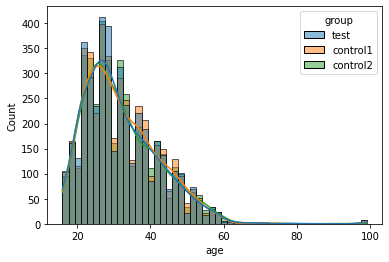

In [216]:
#Let's look at the graph and visually assess the differences between the groups
sns.histplot(data = users_cleaned, x ="age", hue = 'group', bins = 50, kde=True)

In [217]:
#Descriptives
users_cleaned.groupby('group').age.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control1,4268.0,32.083177,10.273384,16.0,24.0,30.0,38.0,99.0
control2,4178.0,32.040929,10.155766,16.0,25.0,30.0,38.0,99.0
test,4233.0,31.877156,10.275162,16.0,25.0,30.0,38.0,99.0


We can see that the mean and range in all groups are approximately the same, so we assume that the groups are equivalent in age. However, this needs to be assessed statistically.

Although the graphs and descriptive statistics suggest that the variances are equal, I will test the homogeneity of the variances using Levene's test.

In [218]:
pg.homoscedasticity(data=users_cleaned, dv="age", group="group")

,W,pval,equal_var
levene,0.300612,0.74037,True


Since Levene's test checkes the following: H0 - the variances are equal and H1 - the variances differ, we conclude that the variances are equal. We can use ANOVA.

H0: the mean age of the users from all groups does not differ, H1 - the mean age of the users from at least one group differs from the mean age of the users from other groups

In [219]:
pg.anova(data=users_cleaned, dv="age", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.479191,0.619295,0.000076


We can see that there are no significant differences. Therefore, the groups are equivalent in age. Let's check the number of men and women in the groups

In [220]:
#Let's see how the gender is encoded
users_cleaned.groupby('group').gender.unique()
#There are 0 and 1, and we don't have any additional information on what means what

group
control1    [0, 1]
control2    [1, 0]
test        [1, 0]
Name: gender, dtype: object

In [221]:
gender_number = users_cleaned.groupby('group')['gender'].value_counts().unstack()

In [222]:
gender_number

gender,0,1
group,,
control1,181,4087
control2,193,3985
test,200,4033


In [223]:
gender_number.div(gender_number.sum(axis=1), axis=0)

gender,0,1
group,,
control1,0.042409,0.957591
control2,0.046194,0.953806
test,0.047248,0.952752


We can see that the ratio is approximately equal,and there are more users with 1 than with 0. Let's check thw differences statistically using the Chi-square (H0 - the ratio of 0 and 1 does not differ between the control and test groups, H1 - the ratio of 0 and 1 differs)

In [224]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_cleaned.group, users_cleaned.gender))
stat, p

(1.2741691534678008, 0.5288319477352809)

The differences are not significant, we cannot reject the null hypothesis. The test and control groups do not differ in the ratio of 0 and 1. We can conclude that the test and control groups are balanced in terms of gender and age.

It is also important to check whether the metrics related to app usage are equal: attraction_coefficient, coins, visit_number, views_count.

Let's use ANOVA. There are more than 4000 users in each group, so it is not necessary to test the distribution, But it is necessary to check the equality of variance (Levene's test). H0 - variances are equal and H1 - variances are different.

In [225]:
pg.homoscedasticity(data=users_cleaned, dv="attraction_coeff", group="group")

,W,pval,equal_var
levene,0.493188,0.610688,True


In [226]:
pg.homoscedasticity(data=users_cleaned, dv="attraction_coeff", group="group")

,W,pval,equal_var
levene,0.493188,0.610688,True


In [227]:
pg.homoscedasticity(data=users_cleaned, dv="coins", group="group")

,W,pval,equal_var
levene,0.961387,0.38239,True


In [228]:
pg.homoscedasticity(data=users_cleaned, dv="visit_number", group="group")

,W,pval,equal_var
levene,0.432524,0.648879,True


In [229]:
pg.homoscedasticity(data=users_cleaned, dv="views_count", group="group")

,W,pval,equal_var
levene,0.868267,0.419703,True


We cannot reject the null hypothesis. The variances do not differ significantly.

In [230]:
#Descriptives
users_cleaned.groupby('group').agg({'attraction_coeff':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())],\
                                   'coins':\
                                 [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

attraction_coeff                                              \
                     mean          sd mode median min   max  skewness   
group                                                                   
control1       311.906279  322.251948    0    235   0  1000  0.715475   
control2       316.280278  326.752131    0    241   0  1000  0.693819   
test           315.117883  323.889972    0    250   0  1000  0.703193   

                        coins                                         \
          kurtosis       mean           sd mode median  min      max   
group                                                                  
control1 -0.672567   0.988988    55.270709  0.0    0.0  0.0   3608.0   
control2 -0.739104  25.064624  1547.434000  0.0    0.0  0.0  99958.0   
test     -0.694691   2.475549   130.608449  0.0    0.0  0.0   8466.0   

                                  
           skewness     kurtosis  
group                             
control1  65.170012  4253.941764  
control2  64.513854  4167.094458  
test      64.350999  4169.518519

In [231]:
#Descriptives
users_cleaned.groupby('group').agg({'visit_number':\
                                 [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())],\
                                    'views_count':\
                                 [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                  ('kurtosis', lambda x: x.kurtosis())]})

visit_number                                                       \
                 mean        sd mode median  min   max  skewness  kurtosis   
group                                                                        
control1     4.566776  6.261693  0.0    2.0  0.0  31.0  1.833189  3.029265   
control2     4.645285  6.342516  0.0    2.0  0.0  31.0  1.809311  2.891300   
test         4.536735  6.155410  0.0    2.0  0.0  31.0  1.839156  3.094394   

         views_count                                                \
                mean          sd mode median min    max   skewness   
group                                                                
control1   41.966261  193.128791    0      6   0   4953  14.323385   
control2   43.207276  316.364024    0      5   0  16157  35.554887   
test       49.492086  319.038940    0      6   0  12831  23.141145   

                       
             kurtosis  
group                  
control1   278.066237  
control2  1667.296756  
test       735.653048

**Attractiion coefficient** H0: The mean values of the attraction coefficient does not differ between the groups, H1 - the mean value of the attraction coefficient in at least one group differs from the mean values of the attraction coefficient in other groups.

In [232]:
pg.anova(data=users_cleaned, dv="attraction_coeff", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.20677,0.813209,0.000033


The differences are not significant, we cannot reject the null hypothesis. The mean value of the attraction coefficient does not differ significantly between the groups.

**Number of coins** H0: The mean number of coins in the groups do not differ, H1 - the mean number of coins in at least one group differs from the mean numbers of coins in other groups.

In [233]:
pg.anova(data=users_cleaned, dv="coins", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.961387,0.38239,0.000152


The differences are not significant, we cannot reject the null hypothesis. The mean number of coins does not differ significantly between the groups.

**Number of app visits** H0: Mean numbers of app visits do not differ between groups, H1: Mean number of app visits in at least one group differ from mean numbers of app visits in other groups.

In [234]:
pg.anova(data=users_cleaned, dv="visit_number", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.337436,0.713604,0.000053


The differences are not significant, we cannot reject the null hypothesis. The mean number of app visits does not differ significantly between the groups.

**Number of views** H0 : Mean numbers of views doesn't differ between the groups, H1 - mean number of views in at least one group differs from the mean numbers of views in other groups

In [235]:
pg.anova(data=users_cleaned, dv="views_count", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,12676,0.867511,0.420021,0.000137


The differences are not significant, we cannot reject the null hypothesis. The mean number of views does not differ significantly between the groups.

Thus, the groups are balanced in all tested socio-demographic characteristics and application usage indicators.

### Step 4

Let's perform a number of additional tests to clarify the data structure, needed to calculate the metrics.

Let's check whether the transactions table includes the data on users who have made a transaction only, and the users table includes all users

In [236]:
transactions_cleaned.query('revenue==0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group


In [237]:
users_cleaned.query('total_revenue==0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,14.0,17
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,0.0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,20.0,26
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,12.0,12
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12907,891937401,63,242,0.0,Italy,1,1,50,66,33,0.0,0.0,0,control2,1.0,1
12908,891692844,35,500,0.0,France,"1,2,3,4,5,6,7",1,24,45,2,0.0,0.0,0,control2,7.0,7
12909,891096429,41,333,0.0,United States of America,"1,2",1,38,44,6,0.0,0.0,0,control2,2.0,2
12910,891697584,48,210,0.0,United Kingdom (Great Britain),2,1,45,51,19,0.0,0.0,0,control2,1.0,2


In [238]:
(transactions_cleaned.uid.nunique() + users_cleaned.query('total_revenue==0').uid.nunique()) ==users_cleaned.uid.nunique() 

False

It turned out that if we add the number of unique users who made a transaction to the users who did not make a transaction, we will not get the total number of users from the users table. Let's look for the source of these discrepancies

In [239]:
(transactions_cleaned.uid.nunique() + users_cleaned.query('total_revenue==0').uid.nunique()) > users_cleaned.uid.nunique() 

True

The number of users who performed a transactions plus users with zero check is larger than the total number of users from 'users' dataset.

In [240]:
set(transactions_cleaned.uid.unique()) - set(users_cleaned.query('total_revenue>0').uid.unique())

{892355163.0}

In [241]:
transactions_cleaned.query("uid == 892355163")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
553,892355163.0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,control1


In [242]:
users_cleaned.query("uid == 892355163")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
7678,892355163,40,640,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,0.0,0,control1,29.0,60


The total revenue from one user has been reset to zero in users_cleaned, but is displayed in transactions. Let's check whether it has been recorded for another user.

In [243]:
users_cleaned.query("total_revenue == 30264")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit


There are no such users. However, total_revenue from 'users_cleaned' represents the normalized revenue. Let's check whether it differs from the revenue from the 'transaction'.

In [244]:
#Let's create a dataframe with the sum of revenues from transactions, deleting user 892355163

revenue_sum = transactions_cleaned.query("uid!=892355163").groupby(["group", "uid"]).agg({'revenue':'sum'}).reset_index()

#Let's create a dataframe with the sum of total revenue from 'users' data

total_revenue = users_cleaned.query('total_revenue>0').groupby(["group", "uid"]).agg({'total_revenue':'sum'}).reset_index()
len(revenue_sum) == len(total_revenue)

True

In [245]:
#The number of rows is equal. Let's look further
transactions_cleaned.revenue.sum() - users_cleaned.total_revenue.sum()

-1586962.0

In [246]:
#The sum is different. Let's merge the dataframes and check line by line
merged_df = revenue_sum.merge(total_revenue, 
           on=['uid', 'group'], how='outer')
merged_df

,group,uid,revenue,total_revenue
0,control1,891092322.0,5278.0,9945
1,control1,891120969.0,6292.0,6292
2,control1,891130164.0,4537.0,11869
3,control1,891131061.0,6292.0,10075
4,control1,891142386.0,4680.0,4680
...,...,...,...,...
368,test,892426491.0,12597.0,12597
369,test,892430988.0,12727.0,12727
370,test,892431081.0,9087.0,9087
371,test,892434141.0,3614.0,9165


In [247]:
#Now I will compare the values
merged_df['difference'] = merged_df['revenue'] - merged_df['total_revenue']

merged_df.query("difference!=0")

,group,uid,revenue,total_revenue,difference
0,control1,891092322.0,5278.0,9945,-4667.0
2,control1,891130164.0,4537.0,11869,-7332.0
3,control1,891131061.0,6292.0,10075,-3783.0
8,control1,891216033.0,6292.0,12584,-6292.0
13,control1,891252072.0,6292.0,8814,-2522.0
...,...,...,...,...,...
354,test,892248561.0,7254.0,38779,-31525.0
355,test,892261437.0,1937.0,3835,-1898.0
359,test,892339626.0,7774.0,17758,-9984.0
366,test,892405179.0,9100.0,13702,-4602.0


We can see that there are discrepancies between the sum of 'transactions' and total revenue from 'users'. Therefore, we know that the revenue from one of the users = 30264 (not equal to 0), but we do not know how exactly the revenue in users was normalized. Therefore, it is better to delete this user

In [248]:
users_cleaned = users_cleaned.query("uid != 892355163")
transactions_cleaned = transactions_cleaned.query("uid != 892355163")

In [249]:
(transactions_cleaned.uid.nunique() + users_cleaned.query('total_revenue==0').uid.nunique()) ==users_cleaned.uid.nunique() 

True

In [250]:
transactions_cleaned.uid.nunique() == users_cleaned.query('total_revenue>0').uid.nunique()

True

The error has been fixed. We can conclude that the total number of users are unique users from 'users', paying users are all unique users from 'transactions'. Next, we I will calculate the metrics based on the normalized total_revenue values from 'users'.

In [251]:
#Let's check which product_types are there in the dataframe
transactions_cleaned.product_type.unique()

array(['trial_premium', 'premium_no_trial', 'other_type'], dtype=object)

In [252]:
#Let's check how many users are there in each of the groups
users_cleaned.query("total_revenue==0").group.value_counts()

test        4126
control1    4126
control2    4053
Name: group, dtype: int64

In [253]:
users_cleaned.query("total_revenue>0").group.value_counts()

control1    141
control2    125
test        107
Name: group, dtype: int64

## Main data analysis
At this stage, I will evaluate the effectiveness of the experiment. For this, three metrics will be users:
- Median revenue per paying user (justification is provided below),
- Conversion to premium subscription,
- Additionally, I will evaluate the conversion to trial subscription, as it should not change.

The analysis will be performed in 2 steps: A/A test (control groups comparison) and A/B test (if the control groups do not differ significantly, I will combine them into one)

I will compare each of the 3 metrics in two pairs of groups (control-control, control-test), so it is necessary to adjust the significance level for the number of pairwise comparisons (there will be have 6 of them).

Also, below I will perform additional analysis in user segments: 2 groups by age, 2 groups by country. Therefore, the p level of significance is adjusted for all 10 pairwise comparisons (the Bonferroni correction).

In [254]:
print(f"p = 0.05/10; p={0.05/10:.3f}")

p = 0.05/10; p=0.005


### A/A test

**1. Median revenue per paying user**

In [255]:
median_rev_p_calc = users_cleaned.query("total_revenue>0") #this dataset includes only unique users

In [256]:
#Let's check the distribution
#H0 - distribution is normal, H1 - distribution is non-normal
pg.normality(data=median_rev_p_calc, dv="total_revenue", group="group", method="normaltest")

,W,pval,normal
test,118.159336,2.197993e-26,False
control1,292.516007,3.026608e-64,False
control2,162.178778,6.071918e-36,False


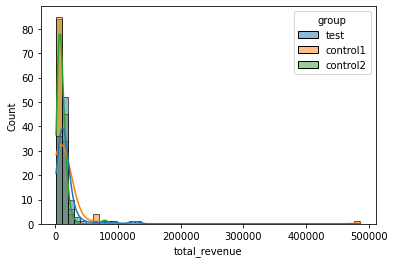

In [257]:
sns.histplot(data = median_rev_p_calc, x ="total_revenue", hue = 'group', bins = 50, kde=True)

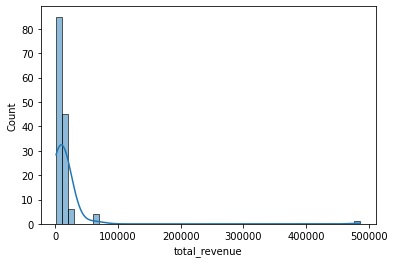

In [258]:
sns.histplot(data = median_rev_p_calc.query("group=='control1'"), x ="total_revenue", bins = 50, kde=True)

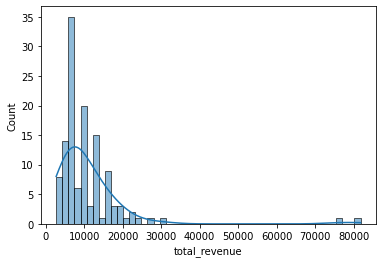

In [259]:
sns.histplot(data = median_rev_p_calc.query("group=='control2'"), x ="total_revenue", bins = 50, kde=True)

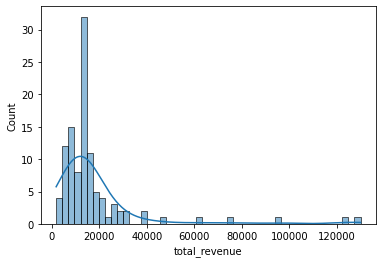

In [260]:
sns.histplot(data = median_rev_p_calc.query("group=='test'"), x ="total_revenue", bins = 50, kde=True)

In [261]:
median_rev_p_calc.groupby('group').agg({'total_revenue':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

total_revenue                                                       \
                  mean            sd   mode median   min     max   skewness   
group                                                                         
control1  15006.978723  41253.814848   6292   9919  1508  486330  10.844778   
control2  10922.184000  10190.422582   6292   8879  2717   81796   4.953360   
test      17676.355140  20084.268328  12727  12727  1898  129870   3.984904   

                      
            kurtosis  
group                 
control1  124.019076  
control2   30.818680  
test       17.672723

In [262]:
median_rev_p_calc.group.value_counts()

control1    141
control2    125
test        107
Name: group, dtype: int64

The distribution is skewed to the left, and there are few paying users in each group. There are outliers that we cannot remove, because they are premium users. Also, there is no additional information, based on which I could include premium users in another segment. Therefore, the mean does not correctly describe the revenue, and in this case it is better to use the median revenue per paying user, rather than ARPPU.

I'll use bootstrapping and compare the medians. H0: the median revenue per paying user of the control groups does not differ. H1 - the medians are different.

In [263]:
pg.compute_bootci(median_rev_p_calc.query("group=='control1'")["total_revenue"],
                  median_rev_p_calc.query("group=='control2'")["total_revenue"],
                  func=lambda x, y: np.median(x) - np.median(y),
                 confidence = 0.995) 

#The confidence level is adjusted according to the Bonferroni correction (1-0.005 = 0.995)

array([-1030.76,  4316.  ])

**Conclusion**. The 99% confidence interval includes 0, so we cannot be sure whether the median in one group is greater or less than in the other. Therefore, we can conclude that there are no significant differences - i.e., we cannot reject the null hypothesis.

**2. Conversion rate**

Let's compare the conversion to premium and the conversion to trial subscription between the users of the control groups.

Conversion can be assessed using the chi-square test. Let's present the data as follows: 1 - the user who purchased the corresponding subscription type during the experiment period, 0 - the user did not purchase the corresponding subscription type). Let's prepare the data.

In [264]:
#Let's create a dataset that includes only users with a trial subscription
trial_premium = transactions_cleaned\
.query("product_type == 'trial_premium'").groupby(['uid', 'group'], as_index = False).agg(trial = ('product_type', 'nunique'))

In [265]:
trial_premium

,uid,group,trial
0,891174411.0,test,1
1,891174534.0,control1,1
2,891175032.0,control1,1
3,891178713.0,control1,1
4,891206280.0,control2,1
...,...,...,...
125,892423284.0,control1,1
126,892430988.0,test,1
127,892431081.0,test,1
128,892438635.0,test,1


In [266]:
#Let's create a dataset that includes only users with a premium subscription
premium = transactions_cleaned\
.query("product_type == 'premium_no_trial'").groupby(['uid', 'group'], as_index = False).agg(premium = ('product_type', 'nunique'))

In [267]:
premium

,uid,group,premium
0,891068079.0,control2,1
1,891071157.0,test,1
2,891077727.0,control2,1
3,891092322.0,control1,1
4,891112263.0,control2,1
...,...,...,...
235,892405224.0,control1,1
236,892421277.0,control1,1
237,892426491.0,test,1
238,892434141.0,test,1


In [268]:
#Let's merge the datasets
#I use full outer join so that unsubscribed users are not deleted
subscriptions = trial_premium.merge(premium, on = ['uid', 'group'], how = 'outer')

In [269]:
#Replacing NaN with 0, meaning there is no subscription
subscriptions = subscriptions.fillna(0)

In [270]:
subscriptions

,uid,group,trial,premium
0,891174411.0,test,1.0,0.0
1,891174534.0,control1,1.0,0.0
2,891175032.0,control1,1.0,0.0
3,891178713.0,control1,1.0,0.0
4,891206280.0,control2,1.0,0.0
...,...,...,...,...
365,892405224.0,control1,0.0,1.0
366,892421277.0,control1,0.0,1.0
367,892426491.0,test,0.0,1.0
368,892434141.0,test,0.0,1.0


In [271]:
conversion = users_cleaned.merge(subscriptions, on = ['uid', 'group'], how = 'outer')
conversion = conversion.fillna(0)

In [272]:
conversion  = conversion[['uid', 'group','trial','premium']]

In [273]:
#Let's check that everything worked correctly
conversion.trial.value_counts()

0.0    12548
1.0      130
Name: trial, dtype: int64

In [274]:
conversion.premium.value_counts()

0.0    12438
1.0      240
Name: premium, dtype: int64

Let's start the analysis using the chi-square test. First, I'll check the **premium subscription**.


H0 - the conversion to a premium subscription does not differ between the control groups, H1 - the conversion to a premium subscription differs between the control groups.

In [275]:
#Creating a crosstab
conversion_AA = conversion.query("group=='control1' or group=='control2'")

In [276]:
pd.crosstab(conversion_AA.group, conversion_AA.premium)

premium,0.0,1.0
group,,
control1,4178,89
control2,4086,92


In [277]:
premium_rate = conversion_AA.groupby('group').premium.value_counts().unstack()
premium_rate.div(premium_rate.sum(axis=1), axis=0)

premium,0.0,1.0
group,,
control1,0.979142,0.020858
control2,0.977980,0.022020


In [278]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(conversion_AA.group, conversion_AA.premium))
stat, p

(0.08621468766091396, 0.7690457103501196)

**Conclusion**. The result is not significant, therefore, we cannot reject the null hypothesis. Conversion to premium subscription does not differ significantly between the control groups.

Let's check the **trial** subscription

H0 - conversion to trial subscription does not differ between control groups, H1 - conversion to trial subscription differs between control groups.

In [279]:
pd.crosstab(conversion_AA.group, conversion_AA.trial)

trial,0.0,1.0
group,,
control1,4216,51
control2,4145,33


In [280]:
trial_rate = conversion_AA.groupby('group').trial.value_counts().unstack()
trial_rate.div(trial_rate.sum(axis=1), axis=0)

trial,0.0,1.0
group,,
control1,0.988048,0.011952
control2,0.992101,0.007899


In [281]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(conversion_AA.group, conversion_AA.trial))
stat, p

(3.1228931153457715, 0.0771996056180697)

**Conclusion**. The result is not significant, therefore, we cannot reject the null hypothesis. Conversion to premium subscription does not differ significantly between the control groups.

The control groups do not differ significantly in any of the metrics of interest. Therefor, if the differences in any of the metrics will be significantly different between the control and test groups, it will be caused by the effect we are testing (change of the premium subscription price).

Let's look again at the number of users in the groups

In [282]:
median_rev_p_calc.group.value_counts() #paying users

control1    141
control2    125
test        107
Name: group, dtype: int64

In [283]:
users_cleaned.group.value_counts() #all users

control1    4267
test        4233
control2    4178
Name: group, dtype: int64

To analyze the results of the A/B test in our conditions, I will combine both control groups into one. In general, there may be several options:

1) Using only one group - but this will reduce statistical power and cause the loss of valuable data from about 4,000 people;

2) Combine the groups into one and randomly take half - however, this can also distort the results;

3) The option used here is to combine the groups into one, which will increase statistical power. However, in this case, the sample size ratio will be approximately 2:1 (control/test).

### A/B test

**1. Median revenue per paying user**

In [284]:
median_rev_p_calc['group'] = median_rev_p_calc.group.apply(lambda x: x.replace('control1', 'control').replace('control2', 'control'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [285]:
median_rev_p_calc

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,visit_number,last_visit
20,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,test,3.0,6
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,test,9.0,9
100,891343671,26,0,24.0,France,"1,2,3,4,5,6,7,8,9",1,23,35,37,1.0,1.0,21580,test,9.0,9
105,892430988,28,181,0.0,United States of America,"1,2",1,25,31,22,1.0,1.0,12727,test,2.0,2
134,891919368,29,250,0.0,France,0,1,26,32,4,1.0,1.0,16536,test,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12799,891826944,36,43,0.0,Germany,"1,2,3,7,8,16,20,22,24",0,27,33,1317,0.0,0.0,6292,control,9.0,24
12810,892385232,23,548,0.0,United States of America,"1,2,3,4,5,6",1,18,32,31,0.0,0.0,6292,control,6.0,6
12838,891452592,49,127,0.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18",1,39,48,837,1.0,0.0,15626,control,18.0,18
12881,891213609,26,363,0.0,United States of America,0,1,23,29,11,0.0,0.0,6292,control,0.0,0


In [286]:
#Let's look at descriptives, because the control group has changed
median_rev_p_calc.groupby('group').agg({'total_revenue':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

total_revenue                                                         \
                 mean            sd   mode   median   min     max   skewness   
group                                                                          
control  13087.432331  30852.364959   6292   9093.5  1508  486330  13.854728   
test     17676.355140  20084.268328  12727  12727.0  1898  129870   3.984904   

                     
           kurtosis  
group                
control  210.915368  
test      17.672723

Performing the bootstrap.
H0: Medians of the control and test groups do not differ. H1 - medians differ.

In [287]:
pg.compute_bootci(median_rev_p_calc.query("group=='test'")["total_revenue"],
                  median_rev_p_calc.query("group=='control'")["total_revenue"],
                  func=lambda x, y: np.median(x) - np.median(y),
                  confidence = 0.995) 

array([2743.  , 5602.99])

In [288]:
median_test = median_rev_p_calc.query("group=='test'").total_revenue.median().round(2)
median_test

12727.0

In [289]:
median_control = median_rev_p_calc.query("group=='control'").total_revenue.median().round(2)
median_control 

9093.5

**Conclusion**. 99% confidence interval does not include 0, therefore, we can reject the null hypothesis. Differences are statistically significant at p=0.005. The median revenue per paying user in the control group is significant lower than median of the test group paying users. Therefore, a increase of the price of premium subscription contributed to a significant increase in median revenue per paying user.

In [299]:
print(f"The increase in premium subscription price contributed to a\
 {((median_test-median_control) / median_control * 100).round(2)}% increase in median revenue per paying user")

The increase in premium subscription price contributed to a 39.96% increase in median revenue per paying user


**2. Conversion rate**

In [294]:
conversion['group'] = conversion.group.apply(lambda x: x.replace('control1', 'control').replace('control2', 'control'))

Checking the **premium** subscription first.

H0 - the conversion to the premium subscription does not differ between test and control groups, H1 - the conversion to the premium subscription is different between the test and control groups.

In [295]:
#Creating a crosstab
conversion_AB = conversion[['uid','group','trial','premium']]
pd.crosstab(conversion_AB.group, conversion_AB.premium)

premium,0.0,1.0
group,,
control,8264,181
test,4174,59


In [296]:
premium_rate_AB = conversion_AB.groupby('group').premium.value_counts().unstack()
premium_rate_AB.div(premium_rate_AB.sum(axis=1), axis=0)

premium,0.0,1.0
group,,
control,0.978567,0.021433
test,0.986062,0.013938


In [297]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(conversion_AB.group, conversion_AB.premium))
stat, p

(8.129180770958094, 0.0043558424321456304)

In [298]:
prem_rate_control = conversion_AB.query("group=='control'").premium.sum() / conversion_AB.query("group=='control'").premium.count()
prem_rate_test = conversion_AB.query("group=='test'").premium.sum() / conversion_AB.query("group=='test'").premium.count()

**Conclusion**. p level is less than the threshold of 0.005, therefore, we can reject the null hypothesis. Increase of the premium subscription price contributed to a significant decrease in conversion to premium subscription

In [300]:
print(f"The increase in premium subscription price contributed to a\
 {abs((prem_rate_test-prem_rate_control) / prem_rate_control * 100).round(2)}% decrease of conversion to a premium subscription")

The increase in premium subscription price contributed to a 34.97% decrease of conversion to a premium subscription


Checking the **trial** subscription.

H0 - the conversion into a trial subscription does not differ between the control and test groups, H1 - the conversion into a trial subscription is different between the control and test groups.

In [301]:
pd.crosstab(conversion_AB.group, conversion_AB.trial)

trial,0.0,1.0
group,,
control,8361,84
test,4187,46


In [302]:
trial_rate_AB = conversion_AB.groupby('group').trial.value_counts().unstack()
trial_rate_AB.div(trial_rate_AB.sum(axis=1), axis=0)

trial,0.0,1.0
group,,
control,0.990053,0.009947
test,0.989133,0.010867


In [303]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(conversion_AB.group, conversion_AB.trial))
stat, p

(0.15335869370321062, 0.6953461134147942)

**Conclusion**. The result is not significant, therefore, we cannot reject the null hypothesis. A change in the premium subscription price did not affect the conversion into a trial subscription.

An increase in the price of premium subscription contributed to a 40% increase in median revenue per paying user and a 35% decrease in the conversion to the premium subscription. Therefore, I will conduct an additional analysis to check whether a 40% percent increase in income is still enough given the decrease in conversion if 35% (i.e., the loss of revenue from the users who decided not to purchase a premium subscription)

To calculate this, we need the following data:
1. Median revenue per paying user when the old price of subscription was used (median revenue per paying user of the control group - 9093.5);

2. Median revenue per paying user after the price was increased (median revenue per paying user of the test group - 12727);

3. Conversion to the premium subscription when the old price of subscription was used: 0.021 (2.1%)

4. Conversion to the premium subscription after the price was increased: 0.014 (1.4%)

5. Number of users:

We made calculations on a sample of 4233 users of the test group. Let's use this number.

Revenue = Conversion * Number of users * Median revenue per paying user

In [304]:
med_rev_before = 9093.5
conversion_before = 0.021
med_rev_after = 12727
conversion_after = 0.014

In [305]:
revenue_before = 4233 * conversion_before * med_rev_before 
revenue_after = 4233 * conversion_after * med_rev_after 

In [306]:
revenue_after - revenue_before

-54121.021499999915

In [307]:
round(abs((revenue_after - revenue_before) / revenue_before * 100),2)

6.7

### **Conclusions**
1. The increase in the cost of premium subscription contributed to a 40% increase of median revenue per paying user;
2. The increase in the cost of premium subscription contributed to a 35% decrease in the conversion to the premium subscription;
3. The growth of median revenue per paying user does not compensate for a decrease in conversion and result in a 7% decrease in total revenue;
4. Therefore, the suggested change of premium subscription price for all users is will lead to a decrease in revenue.

## **Hypotheses testing on user segments**

Let's check whether the effect of the increase in the cost of premium subscription varies depending on the socio-demographic characteristics of users. Here I will test age and country.

In [308]:
segments_df = users_cleaned[['uid','group','age','country','total_revenue']]
segments_df ['group'] = segments_df.group.apply(lambda x: x.replace('control1', 'control').replace('control2', 'control'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [309]:
segments_df

,uid,group,age,country,total_revenue
0,892309896,test,27,United States of America,0
1,892044516,test,27,Germany,0
2,892185708,test,45,Israel,0
3,892130292,test,32,United States of America,0
4,891406035,test,27,France,0
...,...,...,...,...,...
12907,891937401,control,63,Italy,0
12908,891692844,control,35,France,0
12909,891096429,control,41,United States of America,0
12910,891697584,control,48,United Kingdom (Great Britain),0


### **Segments**

**Age**

In [310]:
segments_df.groupby('group').age.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,8445.0,32.061338,10.215027,16.0,24.0,30.0,38.0,99.0
test,4233.0,31.877156,10.275162,16.0,25.0,30.0,38.0,99.0


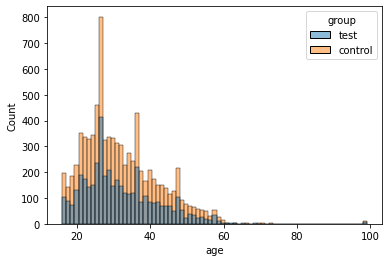

In [311]:
sns.histplot(data = segments_df, x='age', hue = 'group')

In [312]:
#Users about 60+ years of age are outliers
segments_df.query("age>60").groupby(['group','age']).size()

group    age
control  61     5
         62     1
         63     4
         64     1
         65     1
         66     4
         67     1
         70     3
         71     2
         72     1
         73     2
         75     1
         77     1
         78     1
         87     1
         91     1
         92     1
         98     1
         99     9
test     61     3
         62     2
         63     3
         65     3
         68     1
         69     3
         71     1
         76     1
         77     1
         83     1
         98     1
         99     7
dtype: int64

We cannot be sure that the users correctly indicated their age, and a large number of users with the age 99 look suspicious. At the same time, in each of the ages between 80 and 98 there is only 1 person. Since it is important for us to ensure that the age is correctly umputed, in order to compare the age groups, it is necessary to remove all users who are 99 years old, as incorrect data.

In [313]:
segments_df.groupby('group').age.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,8445.0,32.061338,10.215027,16.0,24.0,30.0,38.0,99.0
test,4233.0,31.877156,10.275162,16.0,25.0,30.0,38.0,99.0


Let's look ar the boundaries calculated based on the IQR (interquartile range)

In [314]:
control_lower_bound = 24 - (38-24)*1.5
control_upper_bound = 38 + (38-24)*1.5
test_lower_bound = 25 - (38-25)*1.5
test_upper_bound = 38 + (38-25)*1.5

In [315]:
control_lower_bound, control_upper_bound

(3.0, 59.0)

In [316]:
test_lower_bound, test_upper_bound

(5.5, 57.5)

It turns out that if I delete the outliers based on +/- 1.5 IQR (Interquartile Range), I can cut off an important part of users: we have a lot of users at the age of 60+, which is unlikely to be an intentionally distorted data. Therefore, I will focus on the ideas about the target audience of dating applicationsand our data, in which only several users are at the age of 75+. Let's look at the descriptives if we take all users up to the age of 75 (including).

In [317]:
segments_df.query("age<=75").groupby('group').age.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,8430.0,31.950652,9.875915,16.0,24.0,30.0,38.0,75.0
test,4222.0,31.716959,9.785605,16.0,25.0,30.0,38.0,71.0


The median age is 30 years. I will divide all users to 2 groups: up to 30 years inclusive and over the age of 30 (up to 75 inclusive). I will keep all the rest as Nan

In [318]:
segments_df['age_group'] = segments_df.age\
.apply(lambda x: 1 if x<=30\
               else 2 if 30<x <= 75 else None)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [319]:
segments_df.age_group.unique()

array([ 1.,  2., nan])

**Countries**

In [320]:
segments_df.groupby(['group', 'country'], as_index = False).size()

,group,country,size
0,control,Argentina,781
1,control,Australia,99
2,control,Belgium,195
3,control,Canada,264
4,control,Chile,566
5,control,Colombia,3
6,control,Costa Rica,2
7,control,Dominican Republic,3
8,control,France,731
9,control,Germany,387


In [321]:
segments_df.country.unique()

array(['United States of America', 'Germany', 'Israel', 'France', 'Spain',
       'Australia', 'Italy', 'Argentina', 'Belgium', 'Chile', 'Portugal',
       'United Kingdom (Great Britain)', 'United Arab Emirates', 'Canada',
       'Ukraine', 'Switzerland', 'Mexico', 'Turkey', 'Russian Federation',
       'India', 'Peru', 'Kyrgyzstan', 'Colombia', 'Dominican Republic',
       'Costa Rica'], dtype=object)

I will divide the countries into 2 groups according to the classification of the IMF (International Monetary Fund), because this classification takes into account the quality of life, including income.

1. Developed countries:
    + United States of America
    + Germany
    + France
    + United Kingdom (Great Britain)
    + Canada
    + Australia
    + Switzerland
    + Belgium
    + Israel
    + Spain
    + Italy
    + Portugal
    
2. Developing countries:
   + Turkey
   + Russian Federation
   + India
   + Argentina
   + Chile
   + Peru
   + Colombia
   + Dominican Republic
   + Costa Rica
   + Ukraine
   + Kyrgyzstan
   + United Arab Emirates
   + Mexico

In [322]:
#2
developed = ['United States of America','Germany','France','United Kingdom (Great Britain)','Canada','Australia','Switzerland','Belgium','Israel','Spain', 'Italy','Portugal']
#1
developing = ['Turkey','Russian Federation','India','Argentina','Chile','Peru','Colombia','Dominican Republic','Costa Rica','Ukraine','Kyrgyzstan','United Arab Emirates', 'Mexico']

In [323]:
segments_df['country_group'] = segments_df.country\
.apply(lambda x: 1 if x in developing\
               else 2 if x in developed else None)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [324]:
segments_df.country_group.unique()

array([2, 1])

As a hypothesis, I will try to distinguish the segments based on a combination of all criterea: users under the age of 30 from developed countries, users over the age of 30 from developed countries, users under the age of 30 from developing countries, users over the age of 30 from developing countries. It is important to check how many users are there in each of the groups: if there are too few, it will not work in our sample.

In [325]:
segments_df['segment_full'] = segments_df.apply(lambda x: 'younger_developed' if (x['age_group'] == 1\
and x['country_group'] == 2) else ('younger_developing' if (x['age_group'] == 1 and x['country_group'] == 1)\
else ('older_developed' if (x['age_group'] == 2 and x['country_group'] == 2) else\
('older_developing' if (x['age_group'] == 2 and x['country_group'] == 1) else None))),axis=1)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [328]:
segments_df.groupby('group').segment_full.value_counts() #all users

group    segment_full      
control  younger_developed     3374
         older_developed       3220
         younger_developing     999
         older_developing       837
test     younger_developed     1736
         older_developed       1553
         younger_developing     505
         older_developing       428
Name: segment_full, dtype: int64

In [329]:
segments_revenue = segments_df.query('total_revenue>0') #paying users
segments_revenue.groupby('group').segment_full.value_counts()

group    segment_full      
control  younger_developed     131
         older_developed        90
         younger_developing     29
         older_developing       14
test     older_developed        48
         younger_developed      39
         older_developing       10
         younger_developing      9
Name: segment_full, dtype: int64

We can see that there are few people in each of the four segments calculated for paying users of a test group. This could increase the possibility of incorrect results, especially when using bootstapping, because this method takes the subsamples from the dataset many times. Therefore, I will use the larger segments

In [330]:
#Creating the dataframe for conversion
#Checking that the number of rows in the segments dataset is equal to the conversion dataset
conversion_AB.shape[0]==segments_df.shape[0]

True

In [331]:
segments_conversion = conversion_AB.merge(segments_df, on=['uid','group'])

In [332]:
segments_conversion

,uid,group,trial,premium,age,country,total_revenue,age_group,country_group,segment_full
0,892309896,test,0.0,0.0,27,United States of America,0,1.0,2,younger_developed
1,892044516,test,0.0,0.0,27,Germany,0,1.0,2,younger_developed
2,892185708,test,0.0,0.0,45,Israel,0,2.0,2,older_developed
3,892130292,test,0.0,0.0,32,United States of America,0,2.0,2,older_developed
4,891406035,test,0.0,0.0,27,France,0,1.0,2,younger_developed
...,...,...,...,...,...,...,...,...,...,...
12673,891937401,control,0.0,0.0,63,Italy,0,2.0,2,older_developed
12674,891692844,control,0.0,0.0,35,France,0,2.0,2,older_developed
12675,891096429,control,0.0,0.0,41,United States of America,0,2.0,2,older_developed
12676,891697584,control,0.0,0.0,48,United Kingdom (Great Britain),0,2.0,2,older_developed


### **Analysis on user segments**

**Median revenue per paying user**

First I will analyze the **age segments**

In [333]:
segments_revenue_younger = segments_revenue.query("age_group==1")
segments_revenue_older = segments_revenue.query("age_group==2")

In [334]:
segments_revenue_younger.groupby('group').agg({'total_revenue':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

total_revenue                                                       \
                 mean            sd   mode median   min     max   skewness   
group                                                                        
control  14375.400000  39474.442780   6292   9087  1898  486330  10.980843   
test     18128.229167  20987.887714  12727  12727  4537  123565   3.931688   

                     
           kurtosis  
group                
control  130.549735  
test      16.815402

In [335]:
segments_revenue_older.groupby('group').agg({'total_revenue':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

total_revenue                                                      \
                 mean            sd   mode median   min     max  skewness   
group                                                                       
control  11201.750000   6074.174224   6292   9802  1508   30849  1.095559   
test     16792.637931  19251.670812  12597  12727  1898  129870  4.387960   

                    
          kurtosis  
group               
control   1.047696  
test     22.367739

I will repeat the analysis performed on the whole sample (bootstrapping). 

H0: Medians of the control and test groups among the users under the age of 30 are not different. H1 - medians differ.

In [336]:
pg.compute_bootci(segments_revenue_younger.query("group=='test'")["total_revenue"],
                  segments_revenue_younger.query("group=='control'")["total_revenue"],
                  func=lambda x, y: np.median(x) - np.median(y),
                  confidence = 0.995) 

array([ 750.9 , 7980.46])

**Conclusion** The confidence interval does not include 0. Therefore, we can reject the null hypothesis - the medians of the control and test groups are significantly different.

In [337]:
younger_test = segments_revenue_younger.query("group=='test'").total_revenue.median().round(2)
younger_control = segments_revenue_younger.query("group=='control'").total_revenue.median().round(2)

In [369]:
print(f"The increase in a premium subscription price for users under the age of 30 contributed to a\
 {((younger_test-younger_control) / younger_control * 100).round(2)}%  increase in median revenue per paying user")

The increase in a premium subscription price for users under the age of 30 contributed to a 40.06%  increase in median revenue per paying user


H0: Medians of the control and test groups among the users over the age of 30 are not different. H1 - medians differ.

In [339]:
pg.compute_bootci(segments_revenue_older.query("group=='test'")["total_revenue"],
                  segments_revenue_older.query("group=='control'")["total_revenue"],
                  func=lambda x, y: np.median(x) - np.median(y),
                  confidence = 0.995) 

array([ -65.  , 5523.75])

**Conclusion**. The 99% confidence interval includes 0, so we cannot be sure whether the median in one group is greater or less than in the other. Therefore, we can conclude that there are no significant differences between the control and test groups for paying users over the age of 30 - i.e., we cannot reject the null hypothesis.

**Countries segments**

In [340]:
segments_revenue_developing = segments_revenue.query("country_group==1")
segments_revenue_developed = segments_revenue.query("country_group==2")

In [341]:
segments_revenue_developing.groupby('group').agg({'total_revenue':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode().iloc[0]),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

total_revenue                                                        \
                 mean            sd   mode   median   min     max  skewness   
group                                                                         
control  14137.500000  14283.032629   6292  10224.5  3614   81796  3.545899   
test     24026.052632  30659.570915  12597  12597.0  4914  123565  2.439248   

                    
          kurtosis  
group               
control  14.033487  
test      5.916859

In [342]:
segments_revenue_developed.groupby('group').agg({'total_revenue':\
                                [('mean','mean'),\
                                 ('sd','std'),\
                                 ('mode', lambda x: x.mode()),\
                                 'median','min', 'max',\
                                 ('skewness', lambda x: x.skew()),\
                                 ('kurtosis', lambda x: x.kurtosis())]})

total_revenue                                                       \
                 mean            sd   mode median   min     max   skewness   
group                                                                        
control  12879.310811  33187.714038   6292   9087  1508  486330  13.329663   
test     16305.397727  16919.834854  12727  12727  1898  129870   4.859753   

                     
           kurtosis  
group                
control  189.661046  
test      28.165756

H0: Medians of the control and test groups among the users from the developing countries are not different. H1 - medians differ.

In [343]:
pg.compute_bootci(segments_revenue_developing.query("group=='control'")["total_revenue"],
                  segments_revenue_developing.query("group=='test'")["total_revenue"],
                  func=lambda x, y: np.median(x) - np.median(y),
                 confidence = 0.995) 

array([-10434.46,   7609.93])

**Conclusion**. The 99% confidence interval includes 0, so we cannot be sure whether the median in one group is greater or less than in the other. Therefore, we can conclude that there are no significant differences between the control and test groups for users from developing countries- i.e., we cannot reject the null hypothesis. For users from developing countries the change in premium subscription price didn't affect the median revenue per paying user.

H0: Medians of the control and test groups among the users from the developed countries are not different. H1 - medians differ.


In [345]:
pg.compute_bootci(segments_revenue_developed.query("group=='control'")["total_revenue"],
                  segments_revenue_developed.query("group=='test'")["total_revenue"],
                  func=lambda x, y: np.median(x) - np.median(y),
                 confidence = 0.995) 

array([-7208.39, -2652.  ])

In [346]:
dev_test = segments_revenue_developed.query("group=='test'").total_revenue.median().round(2)
dev_control = segments_revenue_developed.query("group=='control'").total_revenue.median().round(2)

**Conclusion** The 99% confidence interval doesn't include 0, therefore the differences in the median are significant. We  can reject the null hypothesis. Change in the price of premium subscription significantly affected mediation revenue per paying user in developed countries.

In [349]:
print(f"The increase in a premium subscription price for users from developed countries contributed to a\
 {((dev_test-dev_control) / dev_control * 100).round(2)}% increase in median     revenue per paying user")

The increase in a premium subscription price for users from developed countries contributed to a 40.06% increase in median     revenue per paying user


**Conversion rate**

**Age segments**

In [350]:
segments_conversion_younger = segments_conversion.query("age_group==1")
segments_conversion_older = segments_conversion.query("age_group==2")

H0 - the conversion to a premium subscription does not differ between the user sunder the age of 30 from the test and control groups , H1 - the conversion to a premium subscription is different between the users under the age of 30 from the test and control groups

In [351]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(segments_conversion_younger.group, segments_conversion_younger.premium))

stat, p

(15.74582750427699, 7.244755559680884e-05)

In [352]:
younger_prem_rate_control = segments_conversion_younger.query("group=='control'").premium.sum() / segments_conversion_younger.query("group=='control'").premium.count()
younger_prem_rate_test = segments_conversion_younger.query("group=='test'").premium.sum() / segments_conversion_younger.query("group=='test'").premium.count()

In [353]:
younger_prem_rate_control

0.026983764006402927

In [354]:
younger_prem_rate_test

0.011601963409192326

**Conclusion**. The p level is below the threshold of 0.005, therefore, we can reject the null hypothesis. The increase in a premium subscription price significantly affected the conversion to the premium subscription for users under the age of 30.

In [370]:
print(f"The increase in a premium subscription price for users under the age of 30 contributed to a\
 {abs((younger_prem_rate_test-younger_prem_rate_control) / younger_prem_rate_control * 100).round(2)}%\
 decrease in conversion to a      premium subscription")

The increase in a premium subscription price for users under the age of 30 contributed to a 57.0% decrease in conversion to a      premium subscription


H0 - the conversion to a premium subscription does not differ between the users over the age of 30 from the test and control groups , H1 - the conversion to a premium subscription is different between the users over the age of 30s from the test and control groups

In [358]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(segments_conversion_older.group, segments_conversion_older.premium))

stat, p

(0.13502652637362855, 0.7132762534495953)

**Conclusion**. The result is not significant, therefore, we cannot reject the null hypothesis. A change in the premium subscription price did not affect the conversion into a premium subscription for users over the age of 30.

**Countries segments**

In [359]:
segments_conversion_developing = segments_conversion_younger.query("country_group==1")
segments_conversion_developed = segments_conversion_younger.query("country_group==2")

H0 - the conversion to a premium subscription does not differ between the users of the test and control groups from developing countries, H1 - the conversion to a premium subscription is different between the users of the test and control groups from developing countries

In [360]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(segments_conversion_developing.group, segments_conversion_developing.premium))

stat, p

(0.13263738779314715, 0.7157130259762139)

**Conclusion**. The result is not significant, therefore, we cannot reject the null hypothesis. A change in the premium subscription price did not affect the conversion into a premium subscription for users from developing countries.

H0 - the conversion to a premium subscription does not differ between the users of the test and control groups from developed countries, H1 - the conversion to a premium subscription is different between the users of the test and control groups from developed countries

In [361]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(segments_conversion_developed.group, segments_conversion_developed.premium))

stat, p

(17.190775243016915, 3.380740314397622e-05)

In [362]:
conversion_developed_c = segments_conversion_developed.query("group=='control'").premium.sum() / segments_conversion_developed.query("group=='control'").premium.count()
conversion_developed_t = segments_conversion_developed.query("group=='test'").premium.sum() / segments_conversion_developed.query("group=='test'").premium.count()

In [363]:
conversion_developed_c

0.029045643153526972

In [364]:
conversion_developed_t

0.010368663594470046

**Conclusion**. The p level is below the threshold of 0.005, therefore, we can reject the null hypothesis. The increase in a premium subscription price significantly affected the conversion to the premium subscription for users from developed countries.

In [367]:
print(f"The increase in a premium subscription price for users from developed countries contributed to a\
 {abs((conversion_developed_t-conversion_developed_c) / conversion_developed_c * 100).round(2)}% decrease in conversion\
  to a premium subscription")

The increase in a premium subscription price for users from developed countries contributed to a 64.3% decrease in conversion  to a premium subscription


### Counclusions on the segments analysis
   
An increase in a premium subscription price contributed to a change in the following metrics.
+ **For users under the age of 30 inclusive**:
  + A 40% increase in median revenue per paying user
  + A 57% decrease in conversion to a premium subsccription
+ **For users over the age of 30**:
  + No significant effect on median revenue per paying user
  + No significant effect on conversion to a premium subsccription
+ **For users from developing countries**:
  + No significant effect on median revenue per paying user
  + No significant effect on conversion to a premium subsccription
+ **For users from developed countries**:
  + A 40% increase in median revenue per paying user
  + A 64% decrease in conversion to a premium subsccription

Let's calculate the change in revenue for users under the age of 30 and users from developed countries. We need:

+ Median revenue per paying user when the old price of subscription was used ;

+ Median revenue per paying user after the price was increased;

+ Conversion to the premium subscription when the old price of subscription was used;

+ Conversion to the premium subscription after the price was increased.

+ Number of users



Revenue = Conversion * Users * Median revenue per paying user

**Users under the age of 30 inclusive**

In [371]:
y_med_rev_before = younger_control
y_conversion_before = younger_prem_rate_control
y_med_rev_after = younger_test
y_conversion_after = younger_prem_rate_test

number_y = segments_conversion_younger.uid.nunique()


In [377]:
y_revenue_before = number_y * y_conversion_before * y_med_rev_before 
y_revenue_after = number_y * y_conversion_after * y_med_rev_after 
y_revenue_after - y_revenue_before

-645151.2222878352

In [373]:
round(abs((y_revenue_after - y_revenue_before) / y_revenue_before * 100),2)

39.78

**People from developed countries**

In [374]:
dev_med_rev_before = dev_control
dev_conversion_before = conversion_developed_c
dev_med_rev_after = dev_test
dev_conversion_after = conversion_developed_t

dev_number = segments_conversion_developed.uid.nunique()

In [376]:
dev_revenue_before = dev_number * dev_conversion_before * dev_med_rev_before 
dev_revenue_after = dev_number * dev_conversion_after * dev_med_rev_after 
dev_revenue_after - dev_revenue_before

-674396.2244010172

In [378]:
round(abs((dev_revenue_after - dev_revenue_before) / dev_revenue_before * 100),2)

50.0

### Final conclusions and recommendations

1. For a whole group of users, an increase in the premium subscription price contributed to a **40% increase in median revenue per paying user** and **a 35% decrease in conversion to a premium subscription**, which results in a **7% decrease in total income**.
2. For users **over the age of 30** and users **from developing countries** (Turkey, Russia, India, Argentina, Chile, Peru, Colombia, Dominican Republic, Costa Rica, Ukraine, Kyrgyzstan, UAE, Mexico) increase in the premium subscription price **did not lead** to a significant change in median revenue per paying user or conversion to a premium subscription.
3. For the following segments of users, an increase in the premium subscription price resulted in a **a decrease in total revenue**:
 + For users aged **under the age of 30** inclusive - by **40%**;
 + For users from **developed countries** (USA, Germany, France, Great Britain, Canada, Australia, Switzerland, Belgium, Israel, Spain, Italy, Portugal) - by **50%**
4. Therefore, **the increase in a premium subscription price to a suggested amount for all users or users from individual segments is associated with a decrease in total revenue**.
5. The segments of users for which the new premium  subscription price **did not affect median revenue per paying user or conversion to the premium subscription** were identified .
6. It is recommended **not to introduce the price changes** at this stage. If there are enough resources, it is suggested **to repeat the A/B test, increasing the sample of paying users**, as well as reaching a sufficient sample size for testing hypotheses on segments with **a combination of age and country**.
7. Also, other premium subscription price could be tested.